In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, math,datetime,pylab
from scipy.stats import skew, kurtosis
from scipy import stats,signal
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer,confusion_matrix
import scipy as sp
%matplotlib inline
from scipy.fftpack import fft, ifft

In [ ]:
#Load raw time series data

d = pd.read_csv(r'C:\Users\MUR2HO\Data\Z axis data\11.06_Moment_Z_W2_fokus_gleich_04.10.csv')
d.drop(d.iloc[:, :2], inplace=True, axis=1)

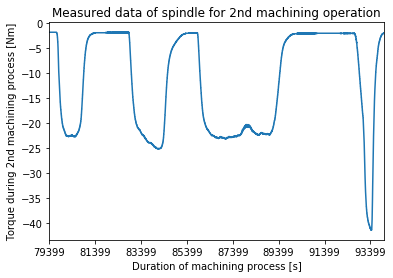

In [3]:
row = d.iloc[1]
row.plot()
plt.xlabel('Duration of machining process [s]')
plt.ylabel('Torque during 2nd machining process [Nm]')
plt.title('Measured data of spindle for 2nd machining operation');

In [4]:
#function to calculate RMS value
def rmsValue(arr): 

      
    #Calculate square 
    sq= np.square(arr) 
      
    #Calculate Mean 
    mean_1 = np.mean(sq)
 
      
    #Calculate Root 
    root = np.sqrt(mean_1) 
      
    return root 

Text(0.5, 1.0, 'Frequency Domain')

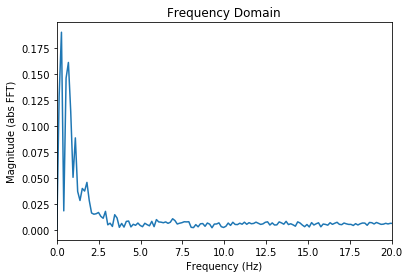

In [7]:
#fft

a=d
a= a[0:1]

start_time = 0 # seconds
end_time = len(a.T)/1000 # seconds
f_s = 1000 # Hz   Sampling frequency 
N = (end_time - start_time)*f_s 
T = 1/f_s # inverse of the sampling rate
x = np.linspace(0.0, 1.0/(2*T), int(N/2))


yt= a.to_numpy() #convert dataframe to array (input to fft in-built function should be array)
z = sp.signal.detrend(yt)

#fft algorithm

yr = fft(z) # "raw" FFT with both + and - frequencies
yre = yr.reshape(len(a.T), 1)
ft = 2/N * np.abs(yre[0:np.int(N/2)]) # positive freqs only

# Plotting the results
plt.xlim(0,20)
plt.plot(x,ft)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (abs FFT)')
plt.title('Frequency Domain')

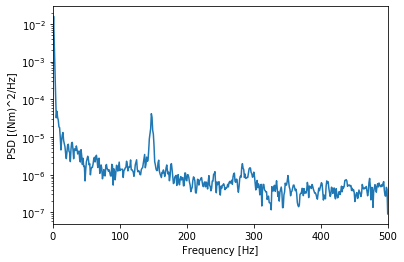

In [12]:
### Power spectral density using Welch method

f_den, Pxx_den = signal.welch(yt, f_s, window='hann',nperseg=1000,noverlap=256)
pxx = Pxx_den.reshape(len(f_den))
plt.semilogy(f_den, pxx)
plt.xlabel('Frequency [Hz]')
plt.xlim(0,500)
plt.ylabel('PSD [(Nm)^2/Hz]')
plt.show()

In [ ]:
####Calculation of Power Spectral Density ----> Welch method W2_Spindle
### https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html


List_psd=[] #initialize an empty list

for j in range(len(d)): #loop iterates over all the rows of the raw data for 04. October
    
    b=d.iloc[j]
    bf = pd.DataFrame(b)
    c= bf.T
    yt= c.to_numpy() #convert dataframe to array (input to fft in-built function should be array)
    z = sp.signal.detrend(yt)
    fx_den, Pxx_den = signal.welch(yt, f_s, window='hann',nperseg=1000)
    pxx = Pxx_den.reshape(len(fx_den))
    
    
    psd_frame =pd.DataFrame(data =pxx, columns=[str(j)])   #creates dataframe of all fft + frequencies
    final_psd= psd_frame.T
    
    
    List_psd.append(final_psd) #append the list with dataframes of fft + frequencies


df_psd = pd.concat(List_psd) #concatenate all the dataframes in the list

In [11]:
t=d.T
k=h.T
############calculate time domain and non-domensional features for Spindle_W2##################

m = np.mean(t)  #mean
s = np.std(t)   #standard deviation
ku = sp.stats.kurtosis(t, fisher=True, bias=True ) #kurtosis
sk = sp.stats.skew(t, axis=0, bias=True) #skewness
median = np.median(t,axis=0) #median
mi = np.min(t) #minimum
ma = np.max(t) #maximum
rms = rmsValue(t) #call rmsValue function 
cf = ma/rms  #crest factor
sf = rms/abs(m)   #shape factor

#Creating Series by passing list of values

sk_new = pd.Series(sk)
sk_new = sk_new.iloc[0:]#.reset_index()
sk_new = sk_new.reset_index(drop=True)
ku_new = pd.Series(ku)
median_new = pd.Series(median)

In [12]:
###################calculate frequency domain features for Spindle_W2##########################

ftr = df.T
p = df_psd.T
ftr1 = df_W3.T
p1 = df_psdp.T

##Features from FFT magnitude spectrum

pkm=np.max(ftr)  #peak magnitude of the spectrum
squar = df.transform(func = lambda x : x**2)
energy = np.sum(squar.T) #spectral energy
mf = np.mean(ftr)  #mean power of spectrum
medianfreq = np.median(ftr,axis=0) #median
medianfreq_new = pd.Series(medianfreq)


##Features from Power spectrum

mbp = np.mean(p)  #mean band power
vbp = np.var(p)   #variance band power
kubp = sp.stats.kurtosis(p, fisher=True, bias=True ) #kurtosis band power
skbp = sp.stats.skew(p, axis=0, bias=True) #skewness band power
maxbp = np.max(p) #maximum band power

#Creating Series by passing list of values

skbp_new = pd.Series(skbp)
skbp_new = skbp_new.iloc[0:]#.reset_index()
skbp_new = skbp_new.reset_index(drop=True)
kubp_new = pd.Series(kubp)

In [ ]:
#Merge Spindle_W2 time-domain features
frames_T_W2 = [m, s, ku_new, sk_new, rms, cf, sf] 
merged_T_W2 = pd.concat(frames_T_W2, axis=1, keys=['Spindle_W2_mean', 'Spindle_W2_std', 'Spindle_W2_kurtosis', 'Spindle_W2_skew','Spindle_W2_RMS','Spindle_W2_CrestFactor','Spindle_W2_ShapeFactor'])
merged_T_W2 = merged_T_W2.reset_index(drop=True)

#Merge Spindle_W2 frequency-domain features
frames_F_W2 = [pkm, energy, mf, mbp, vbp, maxbp] 
merged_F_W2 = pd.concat(frames_F_W2, axis=1, keys=['Spindle_W2_PKM', 'Spindle_W2_Energy', 'Spindle_W2_MF', 'Spindle_W2_MBP','Spindle_W2_VBP','Spindle_W2_MaxBP'])


append1 = merged_T_W2.T.append(merged_F_W2.T)
append2 = append1.append(merged_F_W2.T)
merged_all= append5.T



merged_all.to_csv(r'C:/Users/MUR2HO/Data/Features/Merged_Features_Spindle_W2_and_W3_11.06.csv', index=False, sep=";")

In [ ]:
 ######Feature Selection Method Related with SVMs
    
x = pd.read_csv(r'C:\Users\MUR2HO\Data\Features\Merged_Features_Spindle_W2_and_W3_all.csv', encoding = 'ISO-8859-1', sep=';')
y = pd.read_csv(r'C:\Users\MUR2HO\Data\HPC\Qs Daten_04.10_18_19.02_11.06_Durchmesser und Konzentrizitaet_paarweise_vertauscht.csv', encoding = 'ISO-8859-1', sep=';')

x = x.T[0:29].T   ###All the features
X = x   
 ####Recursive elimination


from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator, 30, step=5)
selector = selector.fit(X, y)

In [36]:
b=selector.ranking_
c=pd.DataFrame(b,columns = ['Ranking'])
tr= c.T
feature = {'Features': ['Spindle_W2_mean', 'Spindle_W2_std', 'Spindle_W2_kurtosis', 'Spindle_W2_skew',
                        'Spindle_W2_RMS','Spindle_W2_CrestFactor','Spindle_W2_ShapeFactor',
                        'Spindle_W2_PKM', 'Spindle_W2_Energy', 'Spindle_W2_MF', 'Spindle_W2_MBP','Spindle_W2_VBP',
                        'Spindle_W2_MaxBP', 'Spindle_W2_KUBP','Spindle_W2_SKBP',
                        'Spindle_W3_mean', 'Spindle_W3_std', 'Spindle_W3_kurtosis', 'Spindle_W3_skew',
                        'Spindle_W3_RMS','Spindle_W3_CrestFactor','Spindle_W3_ShapeFactor','Spindle_W3_PKM', 
                        'Spindle_W3_Energy', 'Spindle_W3_MF', 'Spindle_W3_MBP','Spindle_W3_VBP','Spindle_W3_MaxBP',
                       'Spindle_W3_KUBP','Spindle_W3_SKBP']}

df = pd.DataFrame(feature, columns = ['Features'])
rank=pd.concat([df.T,tr],ignore_index=False)
features_s= rank.T
features_s

,Features,Ranking
0,Spindle_W2_mean,1
1,Spindle_W2_std,1
2,Spindle_W2_kurtosis,1
3,Spindle_W2_skew,1
4,Spindle_W2_RMS,1
5,Spindle_W2_CrestFactor,1
6,Spindle_W2_ShapeFactor,1
7,Spindle_W2_PKM,1
8,Spindle_W2_Energy,1
9,Spindle_W2_MF,1


In [37]:
####Selecting/grouping all the features with rank 1

rslt_df = features_s[(features_s['Ranking'] == 1)] 
rslt_df         

,Features,Ranking
0,Spindle_W2_mean,1
1,Spindle_W2_std,1
2,Spindle_W2_kurtosis,1
3,Spindle_W2_skew,1
4,Spindle_W2_RMS,1
5,Spindle_W2_CrestFactor,1
6,Spindle_W2_ShapeFactor,1
7,Spindle_W2_PKM,1
8,Spindle_W2_Energy,1
9,Spindle_W2_MF,1


In [38]:
# Selects only the top 1 rank features and copies it into the separate .csv file

dr = rslt_df.drop(['Ranking'], axis=1)   ###Drop the column with label 'Ranking' (Keep the column with label'Features')
drl = dr["Features"].tolist() ####covert dataframe column values to list
dfs = X[drl] ######select only the features which are mentioned in the list

dfs.to_csv(r'C:/Users/MUR2HO/Data/Features/Top29_ranked_features.csv', index=False, sep=";")
dfs

,Spindle_W2_mean,Spindle_W2_std,Spindle_W2_kurtosis,Spindle_W2_skew,Spindle_W2_RMS,Spindle_W2_CrestFactor,Spindle_W2_ShapeFactor,Spindle_W2_PKM,Spindle_W2_Energy,Spindle_W2_MF,...,Spindle_W3_RMS,Spindle_W3_CrestFactor,Spindle_W3_ShapeFactor,Spindle_W3_PKM,Spindle_W3_Energy,Spindle_W3_MF,Spindle_W3_MBP,Spindle_W3_VBP,Spindle_W3_MaxBP,Spindle_W3_KUBP
0,-12.193897,10.649121,-1.162746,-0.438143,16.189345,-0.111184,1.327660,7.004554,226.656474,0.010052,...,4.712623,-0.509271,1.001884,0.094239,0.073111,0.000825,0.000054,7.257916e-07,13.206536,420.966237
1,-11.755397,10.242050,-0.992643,-0.476852,15.591310,-0.115449,1.326311,6.805400,209.425580,0.009713,...,4.701372,-0.404137,1.001914,0.086048,0.074864,0.000817,0.000054,7.365246e-07,15.179004,422.885864
2,-11.729219,10.276498,-1.155738,-0.426813,15.594262,-0.109014,1.329523,6.869305,211.044750,0.009899,...,4.784433,-0.480726,1.002904,0.126115,0.119520,0.000877,0.000085,1.895787e-06,12.382491,429.510490
3,-12.190829,10.736817,-1.034028,-0.479729,16.244862,-0.104648,1.332548,7.131964,230.142244,0.010157,...,4.799703,-0.375023,1.003274,0.127849,0.135115,0.000891,0.000101,2.703576e-06,16.173268,430.311656
4,-11.346000,9.920109,-0.887175,-0.502576,15.071174,-0.119433,1.328325,6.332192,196.771164,0.009513,...,4.703762,-0.467711,1.001806,0.093481,0.069048,0.000798,0.000051,6.742675e-07,12.576803,427.883804
5,-11.734068,10.278437,-0.941907,-0.493043,15.599187,-0.115391,1.329393,6.677522,211.232834,0.009808,...,4.711508,-0.466942,1.001853,0.089667,0.071719,0.000594,0.000057,8.139647e-07,13.555123,422.259980
6,-11.337884,9.949515,-0.804325,-0.529863,15.084444,-0.112699,1.330446,6.468488,197.983760,0.009553,...,4.775467,-0.460688,1.002786,0.124227,0.112626,0.000844,0.000085,1.886554e-06,12.388623,429.833413
7,-12.053192,10.522150,-1.114565,-0.440729,15.999846,-0.106251,1.327436,6.808972,221.321553,0.010010,...,4.777513,-0.460491,1.002852,0.125128,0.115686,0.000644,0.000085,1.893091e-06,13.401958,428.394119
8,-11.718822,10.255421,-0.900795,-0.504175,15.572554,-0.115588,1.328850,6.729349,210.338681,0.009752,...,4.720870,-0.508381,1.001837,0.096135,0.070830,0.000761,0.000054,7.475960e-07,12.676220,424.573881
9,-11.657589,10.208117,-0.899584,-0.503180,15.495323,-0.116164,1.329205,6.694438,208.256434,0.009743,...,4.722684,-0.423488,1.001910,0.086117,0.076144,0.000792,0.000057,8.124264e-07,14.954630,414.172322
